In [1]:
!pip install forex-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from forex_python.converter import CurrencyRates

###RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [3]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [4]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [5]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [6]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [7]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [8]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [9]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [10]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [11]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [12]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [14]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [ ]:
df_init = api_to_df('https://justjoin.it/api/offers')

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12988 entries, 0 to 12987
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    12988 non-null  object
 1   street                   12986 non-null  object
 2   city                     12988 non-null  object
 3   country_code             12982 non-null  object
 4   address_text             12988 non-null  object
 5   marker_icon              12988 non-null  object
 6   workplace_type           12988 non-null  object
 7   company_name             12988 non-null  object
 8   company_url              12988 non-null  object
 9   company_size             12988 non-null  object
 10  experience_level         12988 non-null  object
 11  latitude                 12988 non-null  object
 12  longitude                12988 non-null  object
 13  published_at             12988 non-null  object
 14  remote_interview         12988 non-nul

## Select the subset of the data - only "data" marker icon

In [ ]:
# Limit observations to those that have flag 'data'
df_data = df_init[df_init['marker_icon'] == 'data']
df_data.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [ ]:
json_data = []

In [ ]:
offers = list(df_data.id)

In [ ]:
len(offers)

1100

In [ ]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

JSONDecodeError: ignored

In [ ]:
df_data_offers = pd.DataFrame(json_data)
to_csv_date(df_data_offers, 'df_data_offers')

In [ ]:
df_data_offers.info(10)

### Dealing with skills

In [ ]:
print(df_data_offers['skills'][0])

In [ ]:
# Putting all skills into one column

old_data = df_data_offers.to_dict(orient='records')
new_data = []

for index, skills_list in enumerate(df_data_offers['skills']):
    for skill in skills_list:
        new_row = old_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_data.append(new_row)

In [ ]:
new_df = pd.DataFrame(new_data)

In [ ]:
new_df.sample()

In [ ]:
new_df.skill_name.unique()

In [ ]:
new_df.skill_name.nunique()

In [ ]:
clean_df = new_df.copy()
clean_df = standardize_text(clean_df, "title")
clean_df = standardize_text(clean_df, "skill_name")

In [ ]:
clean_df.head(5)

In [ ]:
top_values = clean_df['skill_name'].value_counts().head(20)
top_20_skills = list(top_values.index)

In [ ]:
print(top_20_skills)

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_df['skill_name'].value_counts().iloc[:20].index, y=clean_df['skill_name'].value_counts().iloc[:20].values)
plot.set_title('20 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
# Sprawdzanie i zamiana wartości
common_skills_df = clean_df.copy()
mask = ~common_skills_df['skill_name'].isin(top_20_skills)
common_skills_df.loc[mask, 'skill_name'] = None


In [ ]:
most_common_skills_df = common_skills_df.dropna(subset=['skill_name'])

In [ ]:
most_common_skills_df.reset_index(drop=True, inplace = True)
most_common_skills_df.info()

In [ ]:
most_common_skills_df.skill_name.nunique()

In [ ]:
most_common_skills_df.columns

In [ ]:
dummies = pd.get_dummies(most_common_skills_df['skill_name'], prefix='skill')

for col in dummies.columns:
    dummies[col] *=  most_common_skills_df['skill_level']

# Dołączanie kolumn dummies
aggregated_df = pd.concat([most_common_skills_df, dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_df = aggregated_df.drop('skill_name', axis=1)
aggregated_df = aggregated_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_df = aggregated_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_df = aggregated_df.drop('skill_level', axis=1)

In [ ]:
aggregated_df.info()

## Dealing with experience level - label encoding

In [ ]:
aggregated_df['experience_level'].unique()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])

## Dealing with 'workplace_type', 'country_code'

In [ ]:
aggregated_df['workplace_type'].unique()

In [ ]:
aggregated_df['country_code'].unique()

In [ ]:
aggregated_df[aggregated_df['country_code'].isna()]

In [ ]:
aggregated_df['workplace_type']= label_encoder.fit_transform(aggregated_df['workplace_type'])
aggregated_df['country_code']= label_encoder.fit_transform(aggregated_df['country_code'])


## Dealing with salaries

In [ ]:
df_employment_types = aggregated_df['employment_types'].apply(pd.Series)
df_employment_types.sample()

In [ ]:
df_employment_type_1 = df_employment_types[0].apply(pd.Series, dtype='object')
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_1.sample()

In [ ]:
df_employment_type_2 = df_employment_types[1].apply(pd.Series, dtype='object')
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

In [ ]:
df_no_employment = aggregated_df.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.info()

In [ ]:
df_employment['type']= label_encoder.fit_transform(df_employment['type'])

### Convert all currencies to PLN

In [ ]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

In [ ]:
selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

In [ ]:
df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

In [ ]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

In [ ]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

In [ ]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [ ]:
df_pln = pd.concat([df_with_salary, df_no_salary])
df_pln.reset_index(drop=True, inplace = True)
df_pln.info()

### Convert company_size to avg_company_size



In [ ]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df_pln[df_pln['company_size'].str.contains('-')][['company_size']]
company_size_df

In [ ]:
company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

In [ ]:
company_size_df[company_size_df['company_size']=='-']

In [ ]:
company_size_df = company_size_df[company_size_df['company_size'] != '-']
company_size_df[company_size_df['company_size']=='-']

In [ ]:
# company_size_df = company_size_df.copy()
company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

In [ ]:
df_avg_company_size = pd.merge(df_pln, company_size_df, left_index=True, right_index=True, how = 'outer')

In [ ]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

In [ ]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

In [ ]:
df_avg_company_size['company_size'] = pd.to_numeric(df_avg_company_size['company_size'])

In [ ]:
df_avg_company_size['avg_company_size'] = df_avg_company_size.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

In [ ]:
df_avg_company_size.info()

In [ ]:
to_csv_date(df_avg_company_size,'offers_API_ready_to_analyze')

# BUILDING REGRESSION MODEL

In [15]:
# df_reg = df_avg_company_size.copy()
df_reg = pd.read_csv('offers_API_ready_to_analyze_08272023.csv')
#pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/ready_to_analyze_08252023_.csv')

In [16]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1038 non-null   object 
 1   apply_body               0 non-null      float64
 2   title                    1038 non-null   object 
 3   street                   1038 non-null   object 
 4   city                     1038 non-null   object 
 5   country_code             1038 non-null   int64  
 6   address_text             1038 non-null   object 
 7   marker_icon              1038 non-null   object 
 8   workplace_type           1038 non-null   int64  
 9   company_name             1038 non-null   object 
 10  company_url              1038 non-null   object 
 11  company_size             1035 non-null   float64
 12  experience_level         1038 non-null   int64  
 13  latitude                 1038 non-null   float64
 14  longitude               

In [17]:
# remove columns that won't be taken into consideration
df_reg_limit=df_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])


In [18]:
df_reg_limit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            1038 non-null   int64  
 1   workplace_type          1038 non-null   int64  
 2   experience_level        1038 non-null   int64  
 3   remote                  1038 non-null   bool   
 4   skill_aws               1038 non-null   int64  
 5   skill_azure             1038 non-null   int64  
 6   skill_big data          1038 non-null   int64  
 7   skill_data              1038 non-null   int64  
 8   skill_databricks        1038 non-null   int64  
 9   skill_dwh               1038 non-null   int64  
 10  skill_english           1038 non-null   int64  
 11  skill_etl               1038 non-null   int64  
 12  skill_java              1038 non-null   int64  
 13  skill_machine learning  1038 non-null   int64  
 14  skill_oracle            1038 non-null   

In [19]:
# extract rows with no salary information
df_no_salaries = df_reg_limit[df_reg_limit['to'].isna()].reset_index(drop=True)
df_no_salaries.info()

# extract rows with salary information
df_salaries = df_reg_limit[df_reg_limit['to'].notna()].reset_index(drop=True)
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            324 non-null    int64  
 1   workplace_type          324 non-null    int64  
 2   experience_level        324 non-null    int64  
 3   remote                  324 non-null    bool   
 4   skill_aws               324 non-null    int64  
 5   skill_azure             324 non-null    int64  
 6   skill_big data          324 non-null    int64  
 7   skill_data              324 non-null    int64  
 8   skill_databricks        324 non-null    int64  
 9   skill_dwh               324 non-null    int64  
 10  skill_english           324 non-null    int64  
 11  skill_etl               324 non-null    int64  
 12  skill_java              324 non-null    int64  
 13  skill_machine learning  324 non-null    int64  
 14  skill_oracle            324 non-null    in

In [20]:
df_salaries_sorted = df_salaries.sort_values(by='from', ascending=True)
df_salaries_sorted.head()

,country_code,workplace_type,experience_level,remote,skill_aws,skill_azure,skill_big data,skill_data,skill_databricks,skill_dwh,...,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_tableau,type,from,to,avg_company_size
626,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,1,0,2,3600.0,5090.0,75.0
369,6,1,0,False,0,0,0,0,0,0,...,0,0,0,0,3,0,2,4000.0,7000.0,25.0
359,6,0,0,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,4337.0,6133.0,75.0
539,6,2,0,True,0,0,0,0,0,0,...,0,0,0,0,2,0,1,4500.0,5000.0,1000.0
248,6,1,0,False,0,0,0,3,0,0,...,0,0,0,0,0,0,2,4500.0,5500.0,87.0


### Salary_from: Random Forest + GridSearchCV

In [23]:
# select X and y
X_from = df_salaries_sorted.drop(columns=['from','to'])
y_from = df_salaries_sorted['from']

# normalize the data
scl = StandardScaler()
X_scaled_from = pd.DataFrame(scl.fit_transform(X_from), columns = X_from.columns)

# split the dataset into training and test sets, salary_from and salary_to are investigated separately
X_train_from, X_test_from, y_train_from, y_test_from = train_test_split(X_scaled_from, y_from, test_size=0.2)

# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs_from = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs_from.fit(X_train_from, y_train_from)

# Get the best model with tuned hyperparameters
best_model_from = gs_from.best_estimator_

# Print best parameters
print("Best Parameters:", gs_from.best_params_)

# Predict on the test set
y_pred_from = best_model_from.predict(X_test_from)

# Evaluate the best model
evaluate_regression_model(best_model_from, X_test_from, y_test_from)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Regression Model Evaluation:
Mean Absolute Error (MAE): 588.36
Mean Squared Error (MSE): 2651418.29
Root Mean Squared Error (RMSE): 1628.32
R-squared (R2): 0.95


### Salary_from: comparision of real and predicted y for train and test set

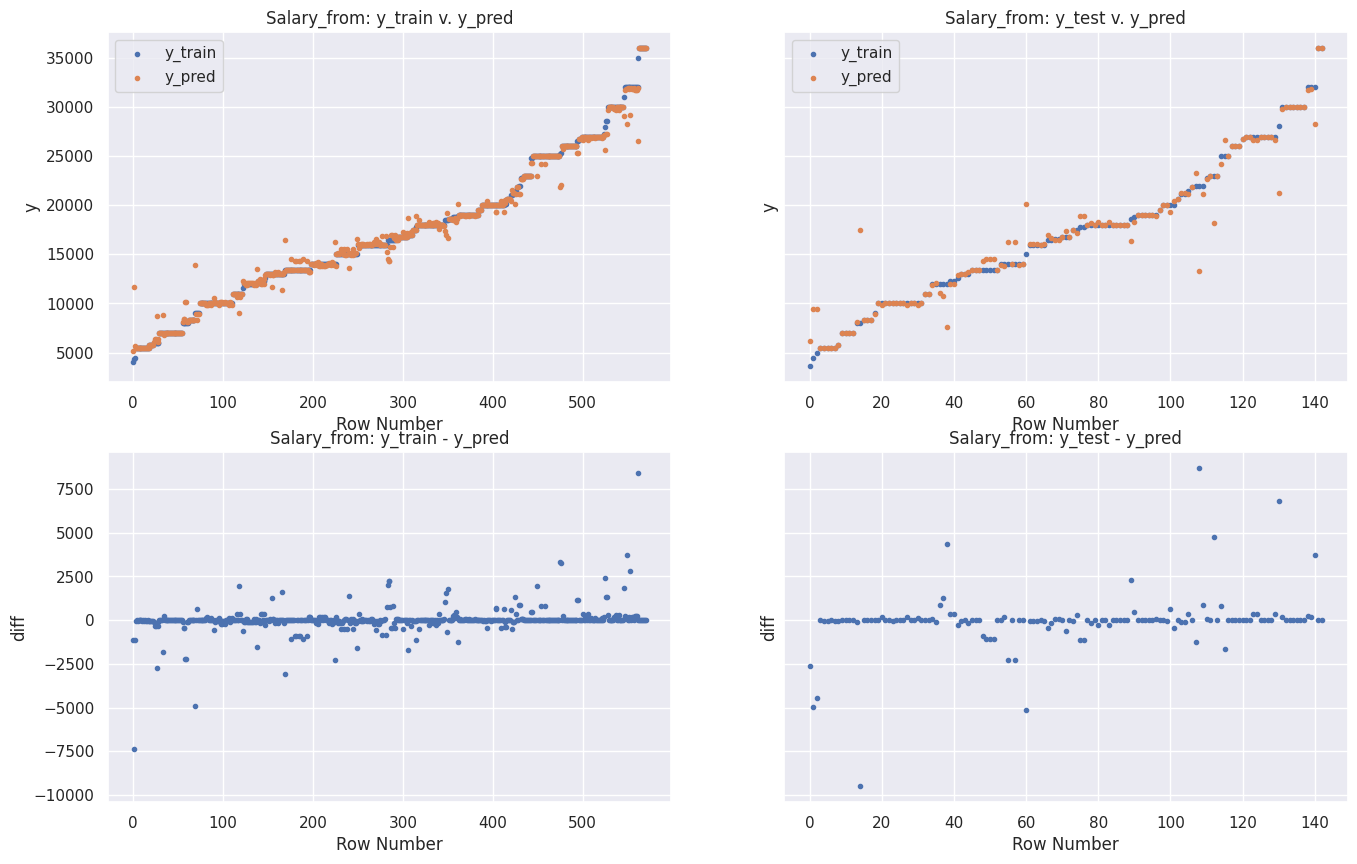

In [53]:
# df with real and predicted y for the train set
y_pred_train_from = best_model_from.predict(X_train_from)
df_train_from = {'y_train': y_train_from, 'y_pred_train': y_pred_train_from, 'train_diff': y_train_from-y_pred_train_from}
df_train_from = pd.DataFrame(df_train_from)
df_train_from.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test_from = best_model_from.predict(X_test_from)
df_test_from = {'y_test': y_test_from, 'y_pred_test': y_pred_test_from, 'test_diff': y_test_from-y_pred_test_from}
df_test_from = pd.DataFrame(df_test_from)
df_test_from.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train_from = range(len(df_train_from))
length_test_from = range(len(df_test_from))

# Salary_from: y_train v. y_pred
axis[0, 0].scatter(length_train_from, df_train_from['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train_from, df_train_from['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary_from: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary_from: y_train - y_pred
axis[1, 0].scatter(length_train_from, df_train_from['train_diff'], marker = '.')
axis[1, 0].set_title("Salary_from: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary_from: y_test v. y_pred
axis[0, 1].scatter(length_test_from, df_test_from['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test_from, df_test_from['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary_from: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary_from: y_test - y_pred
axis[1, 1].scatter(length_test_from, df_test_from['test_diff'], marker = '.')
axis[1, 1].set_title("Salary_from: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()

### Salary_to: Random Forest + **GridSearchCV**

In [43]:
# select X and y
X_to = df_salaries.drop(columns=['from','to'])
y_to = df_salaries['to']

# normalize the data
scl = StandardScaler()
X_scaled_to = pd.DataFrame(scl.fit_transform(X_to), columns = X_to.columns)

# split the dataset into training and test sets, salary_from and salary_to are investigated separately
X_train_to, X_test_to, y_train_to, y_test_to = train_test_split(X_scaled_to, y_to, test_size=0.2)

# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs_to = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs_to.fit(X_train_to, y_train_to)

# Get the best model with tuned hyperparameters
best_model_to = gs_to.best_estimator_

# Print best parameters
print("Best Parameters:", gs_to.best_params_)

# Evaluate the best model
evaluate_regression_model(best_model_to, X_test_to, y_test_to)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Regression Model Evaluation:
Mean Absolute Error (MAE): 596.94
Mean Squared Error (MSE): 2573770.67
Root Mean Squared Error (RMSE): 1604.30
R-squared (R2): 0.96


### Salary_to: comparision of real and predicted y for train and test set

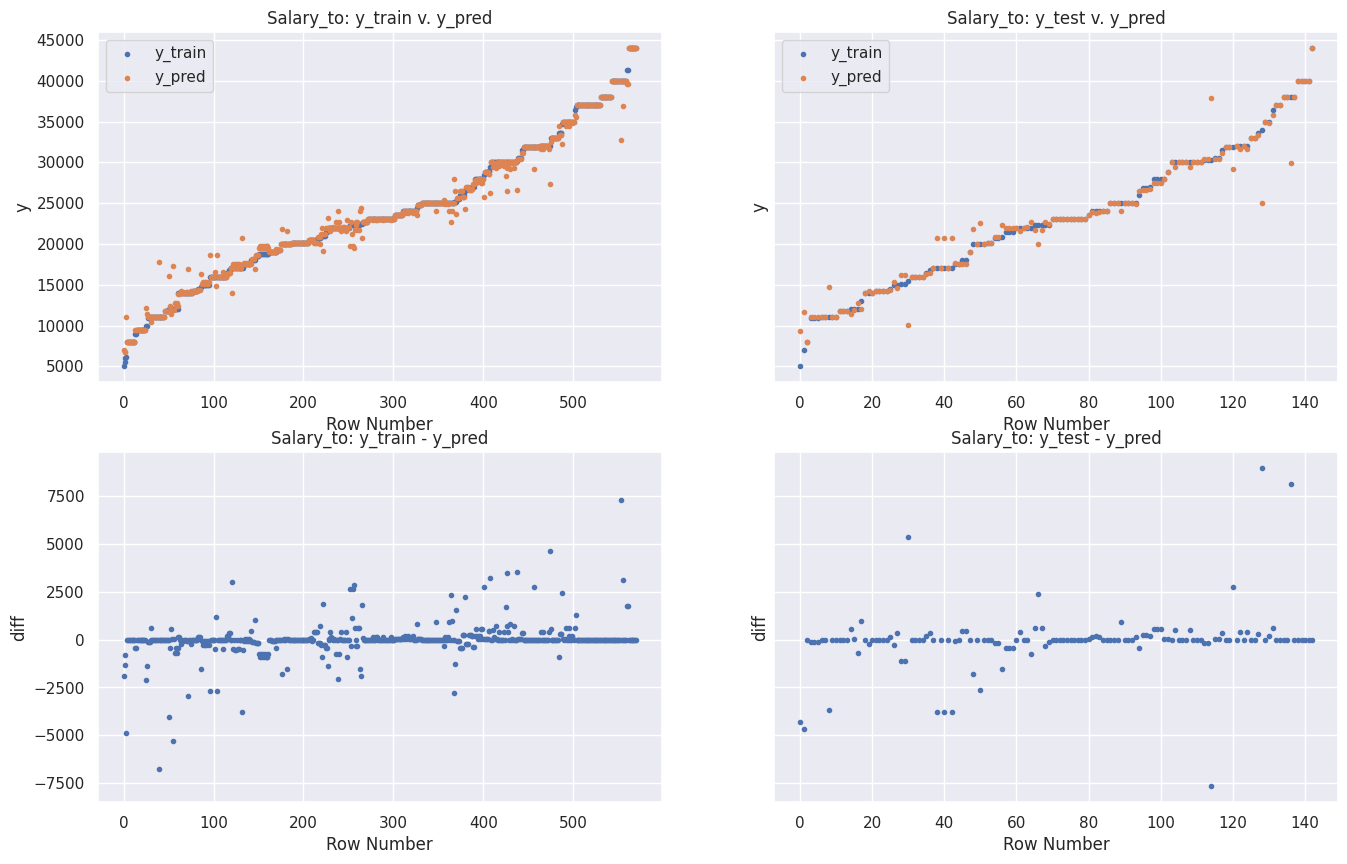

In [54]:
# df with real and predicted y for the train set
y_pred_train_to = best_model_to.predict(X_train_to)
df_train_to = {'y_train': y_train_to, 'y_pred_train': y_pred_train_to, 'train_diff': y_train_to-y_pred_train_to}
df_train_to = pd.DataFrame(df_train_to)
df_train_to.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test_to = best_model_to.predict(X_test_to)
df_test_to = {'y_test': y_test_to, 'y_pred_test': y_pred_test_to, 'test_diff': y_test_to-y_pred_test_to}
df_test_to = pd.DataFrame(df_test_to)
df_test_to.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train_to = range(len(df_train_to))
length_test_to = range(len(df_test_to))

# Salary_to: y_train v. y_pred
axis[0, 0].scatter(length_train_to, df_train_to['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train_to, df_train_to['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary_to: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary_to: y_train - y_pred
axis[1, 0].scatter(length_train_to, df_train_to['train_diff'], marker = '.')
axis[1, 0].set_title("Salary_to: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary_to: y_test v. y_pred
axis[0, 1].scatter(length_test_to, df_test_to['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test_to, df_test_to['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary_to: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary_to: y_test - y_pred
axis[1, 1].scatter(length_test_to, df_test_to['test_diff'], marker = '.')
axis[1, 1].set_title("Salary_to: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()

##MAE distribution

<Axes: ylabel='Count'>

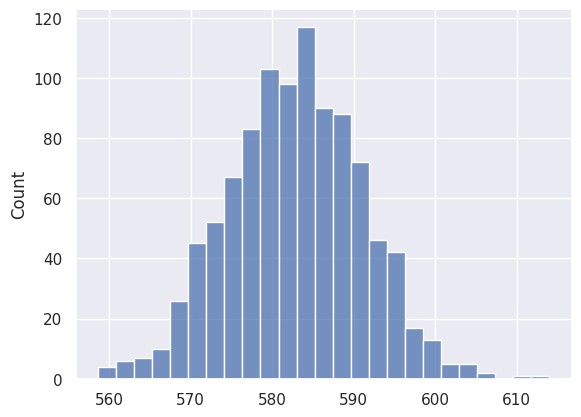

In [90]:
mae_from = []

for i in range(1000):

    model_from = RandomForestRegressor(max_depth = None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
    # model_from = RandomForestRegressor(best_model_from.get_params())
    model_from.fit(X_train_from, y_train_from)

    mae_from.append(mean_absolute_error(y_test_from, model_from.predict(X_test_from)))

sns.set_style("darkgrid")
sns.histplot(mae_from)

<Axes: ylabel='Count'>

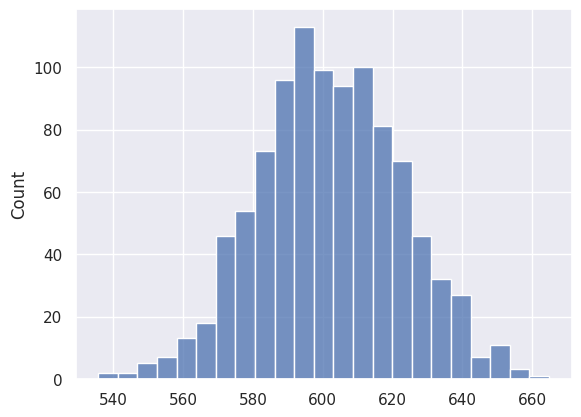

In [91]:
from sklearn import model_selection
mae_to = []

for i in range(1000):

    model_to = RandomForestRegressor(max_depth = 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)
    # model_to = RandomForestRegressor(best_model_to.get_params())
    model_to.fit(X_train_to, y_train_to)

    mae_to.append(mean_absolute_error(y_test_to, model_to.predict(X_test_to)))

sns.set_style("darkgrid")
sns.histplot(mae_to)

In [ ]:
# saving model
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

joblib.dump(best_model_from, f"best_model_from_{scikit_version}.pkl")
joblib.dump(best_model_to, f"best_model_to_{scikit_version}.pkl")

# Reading job offer and preparing the data

In [ ]:
job_offer = 'https://justjoin.it/offers/opi-pib-analityk-danych-warszawa'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [ ]:
response = requests.get(job_offer_api)
job_data = response.json()

In [ ]:
with open('output.txt', 'r') as file:
    lines = file.readlines()
    top_20_skills = [line.strip() for line in lines]

print(top_20_skills)

In [ ]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")

offer_dummies = pd.DataFrame()

for col_name in sorted(top_20_skills):
    offer_dummies["skill_" + col_name] = 0

offer_dummies.loc[0] = 0

In [ ]:
final = []
for skill in offer_df['skill_name']:
    new_dummy = offer_dummies.copy()
    if skill in top_20_skills:
        new_dummy[f"skill_{skill}"] = 1
    final.append(new_dummy)

all_dummies = pd.concat(final, ignore_index=True)

In [ ]:



for col in all_dummies.columns:
    all_dummies[col] *=  common_skills_offer_df['skill_level']

# Dołączanie kolumn dummies
aggregated_offer_df = pd.concat([common_skills_offer_df, all_dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_offer_df = aggregated_offer_df.drop('skill_name', axis=1)
aggregated_offer_df = aggregated_offer_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_offer_df = aggregated_offer_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_offer_df = aggregated_offer_df.drop('skill_level', axis=1)

label_encoder = preprocessing.LabelEncoder()
aggregated_offer_df['experience_level']= label_encoder.fit_transform(aggregated_offer_df['experience_level'])
aggregated_offer_df['workplace_type']= label_encoder.fit_transform(aggregated_offer_df['workplace_type'])
aggregated_offer_df['country_code']= label_encoder.fit_transform(aggregated_offer_df['country_code'])



In [ ]:
offer_employment_types = aggregated_offer_df['employment_types'].apply(pd.Series)
offer_employment_type = offer_employment_types[0].apply(pd.Series)
offer_employment_type= pd.concat([offer_employment_type.drop(['salary'], axis=1),
                                 offer_employment_type['salary'].apply(pd.Series)], axis=1)

offer_no_employment = aggregated_offer_df.drop(columns = 'employment_types')
offer_employment = pd.concat([offer_no_employment, offer_employment_type], axis = 1)

offer_employment['type']= label_encoder.fit_transform(offer_employment['type'])

offer_employment.reset_index(drop=True, inplace = True)

company_size_offer = offer_employment[offer_employment['company_size'].str.contains('-')][['company_size']]

company_size_offer['company_size_1'] = company_size_offer['company_size'].str.split('-').str[0]
company_size_offer['company_size_2']  = company_size_offer['company_size'].str.split('-').str[-1]

company_size_offer['company_size_1'] = pd.to_numeric(company_size_offer['company_size_1'])
company_size_offer['company_size_2'] = pd.to_numeric(company_size_offer['company_size_2'])
company_size_offer['avg_company_size'] = (company_size_offer['company_size_1'] + company_size_offer['company_size_2']) / 2

company_size_offer = company_size_offer[['avg_company_size']]

offer = pd.merge(offer_employment, company_size_offer, left_index=True, right_index=True, how = 'outer')

offer['company_size'] = offer['company_size'].apply(remove_mark)
offer['company_size'] = offer['company_size'].apply(remove_mark)
offer['company_size'] = offer['company_size'].apply(remove_blanc)

offer['avg_company_size'] = offer.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

offer=offer.drop(columns = ['id', 'from', 'to', 'currency', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation'])

offer_scaled = pd.DataFrame(scl.fit_transform(offer), columns = offer.columns)

In [ ]:
# Predict on the test set
pred = RF_model.predict(offer_scaled)
print(pred)